# 1. Load Data

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from datacleaner import autoclean
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [10]:
salaries = pd.read_csv('data/salaries.csv')
salaries = salaries.sample(frac=0.05, random_state=0)
salaries['income'] = np.where(salaries['income'] == '<=50K', 0, 1)

# 2. Data Preprocessing

In [22]:
def drop_duplicate_rows(df):
    return df.drop_duplicates(keep='first')

def normalize_features(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
    return df_scaled

def split_dataset(df, target_col):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
    X_train, X_test = train_df.drop(target_col, axis=1), test_df.drop(target_col, axis=1)
    y_train, y_test = train_df[target_col], test_df[target_col]
    return X_train, y_train, X_test, y_test

In [24]:
salaries = autoclean(salaries)
salaries = drop_duplicate_rows(salaries)
salaries = normalize_features(salaries)
salaries_X_train, salaries_y_train,  salaries_X_test, salaries_y_test, = split_dataset(salaries, 'income')

# 3. Utility functions for model evaluation

In [52]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    f1_scorer = make_scorer(f1_score, average='weighted')
    train_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_scorer)
    test_scores = cross_val_score(model, X_test, y_test, cv=5, scoring=f1_scorer)
    return np.mean(train_scores), np.std(train_scores), np.mean(test_scores), np.std(test_scores)

def plot_learning_curve(model, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='f1_weighted')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label="Testing")
    plt.legend(loc="best")
    plt.show()

def plot_complexity_curve(model, X, y, param_name, param_range, cv=5, n_jobs=-1):
    train_scores, test_scores = validation_curve(model, X, y, param_name=param_name, param_range=param_range, cv=5, scoring='f1_weighted')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')
    plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training")
    plt.plot(param_range, test_scores_mean, 'o-', color='orange', label="Testing")
    plt.legend(loc="best")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.show()
    
def optimize_model(model, X_train, y_train, param_grid):
    f1_scorer = make_scorer(f1_score, average='weighted')
    grid_search = GridSearchCV(model, param_grid=param_grid, scoring=f1_scorer, cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

def compare_models(default_model, optimized_model, X_test, y_test):
    default_f1_score = f1_score(y_test, default_model.predict(X_test), average='weighted')
    optimized_f1_score = f1_score(y_test, optimized_model.predict(X_test), average='weighted')
    print("Default model f1-weighted score:", default_f1_score)
    print("Optimized model f1-weighted score:", optimized_f1_score)


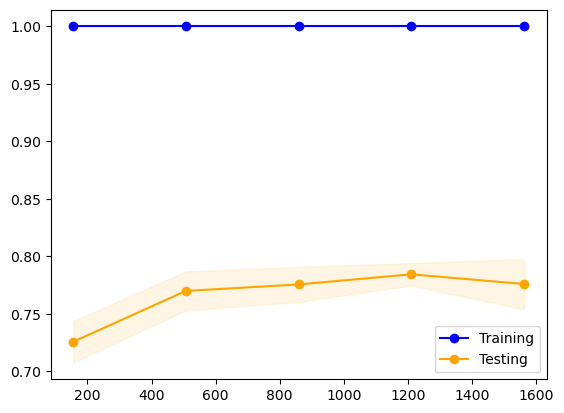

In [36]:
# initialize decision tree model
dt = DecisionTreeClassifier()
# plot learning curve
plot_learning_curve(dt, salaries_X_train, salaries_y_train, cv=5, n_jobs=-1)

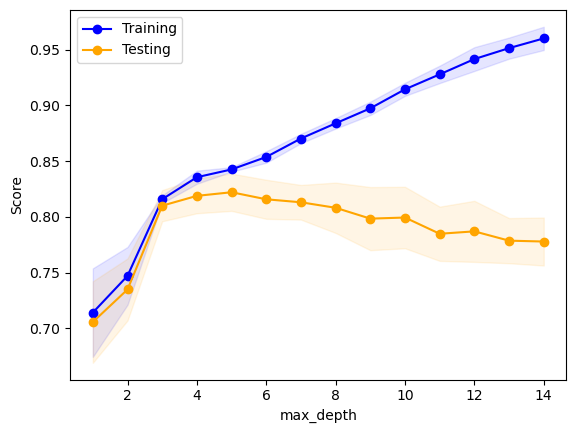

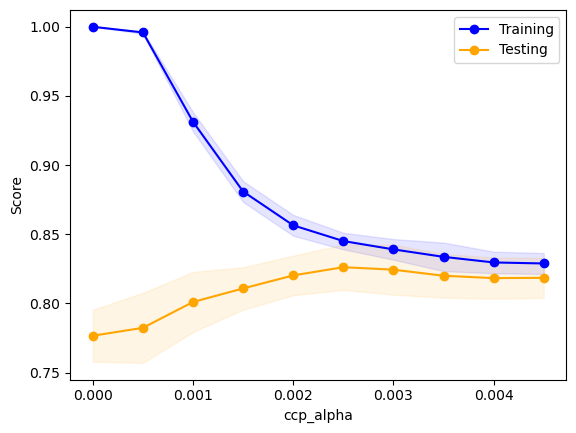

In [42]:
# plot complexity curve
param_name = 'max_depth'
param_range = range(1, 15)
plot_complexity_curve(dt, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'ccp_alpha'
param_range = np.arange(0.000, 0.005, 0.0005)
plot_complexity_curve(dt, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)


#plt.show()

In [59]:
# use gridsearch cv to identify the best parameters
dt_param_grid = {'max_depth': range(1, 15), 'ccp_alpha': np.arange(0.000, 0.005, 0.0005)}
dt_best_model, dt_best_params = optimize_model(dt, salaries_X_train, salaries_y_train, dt_param_grid)
dt_best_model.fit(salaries_X_train, salaries_y_train)

# evaluate base model and optimal model
dt_base_report = evaluate_model(dt, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
dt_opt_report = evaluate_model(dt_best_model, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)

# compare f1_weighted score of base model and optimal model
dt_scores = {'Base Model': dt_base_report[0], 'Optimal Model': dt_opt_report[0]}
dt_score_df = pd.DataFrame(list(scores.items()), columns=['Model', 'f1_weighted_score'])
dt_score_df


           Model  f1_weighted_score
0     Base Model           0.769849
1  Optimal Model           0.826223


In [61]:
print(dt_best_params)

{'ccp_alpha': 0.0025, 'max_depth': 9}


In [60]:
score_df

,Model,f1_weighted_score
0,Base Model,0.769849
1,Optimal Model,0.826223


In [ ]:
# initialize decision tree model
dt = DecisionTreeClassifier()
# plot learning curve
plot_learning_curve(dt, salaries_X_train, salaries_y_train, cv=5, n_jobs=-1)


# plot complexity curve
param_name = 'max_depth'
param_range = range(1, 15)
plot_complexity_curve(dt, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'ccp_alpha'
param_range = np.arange(0.000, 0.005, 0.0005)
plot_complexity_curve(dt, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)


# use gridsearch cv to identify the best parameters
dt_param_grid = {'max_depth': range(1, 15), 'ccp_alpha': np.arange(0.000, 0.005, 0.0005)}
dt_best_model, dt_best_params = optimize_model(dt, salaries_X_train, salaries_y_train, dt_param_grid)
dt_best_model.fit(salaries_X_train, salaries_y_train)

# evaluate base model and optimal model
dt_base_report = evaluate_model(dt, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
dt_opt_report = evaluate_model(dt_best_model, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)

# compare f1_weighted score of base model and optimal model
dt_scores = {'Base Model': dt_base_report[0], 'Optimal Model': dt_opt_report[0]}
dt_score_df = pd.DataFrame(list(scores.items()), columns=['Model', 'f1_weighted_score'])

print('dt best params for salaries')
print(dt_best_params)
dt_score_df

#plt.show()

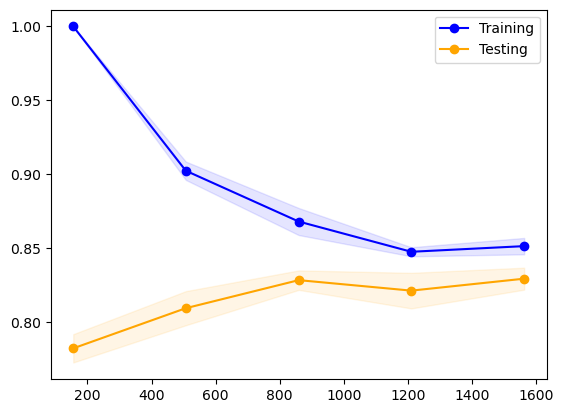

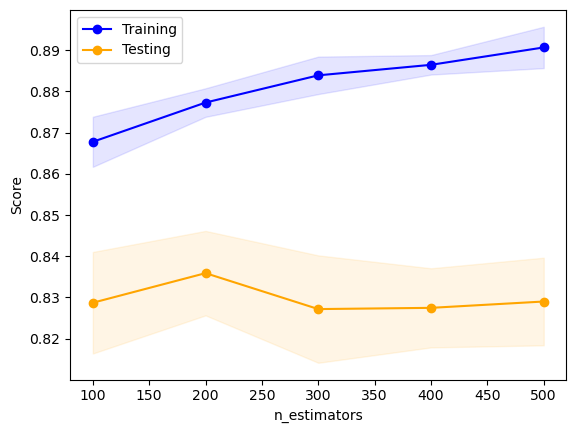

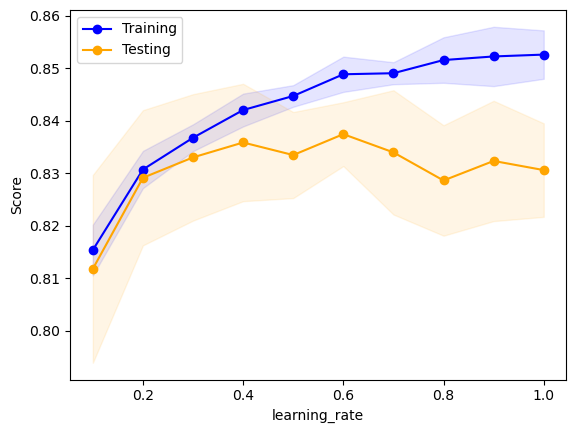

ada best params for salaries
{'learning_rate': 0.30000000000000004, 'n_estimators': 300}


,Model,f1_weighted_score
0,Base Model,0.830597
1,Optimal Model,0.841857


In [62]:
#initialize Adaboost model
ada = AdaBoostClassifier()
plot_learning_curve(ada, salaries_X_train, salaries_y_train, cv=5, n_jobs=-1)

param_name = 'n_estimators'
param_range = range(100, 600, 100)
plot_complexity_curve(ada, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'learning_rate'
param_range = np.arange(0.1, 1.1, 0.1)
plot_complexity_curve(ada, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)


ada_param_grid = {'n_estimators':  range(100, 600, 100), 'learning_rate': np.arange(0.1, 1.1, 0.1)}
ada_best_model, ada_best_params = optimize_model(ada, salaries_X_train, salaries_y_train, ada_param_grid)
ada_best_model.fit(salaries_X_train, salaries_y_train)


ada_base_report = evaluate_model(ada, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
ada_opt_report = evaluate_model(ada_best_model, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)


ada_scores = {'Base Model': ada_base_report[0], 'Optimal Model': ada_opt_report[0]}
ada_score_df = pd.DataFrame(list(ada_scores.items()), columns=['Model', 'f1_weighted_score'])

print('ada best params for salaries')
print(ada_best_params)

ada_score_df

#plt.show()

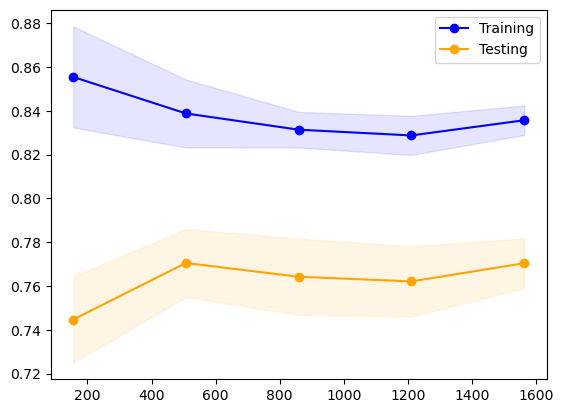

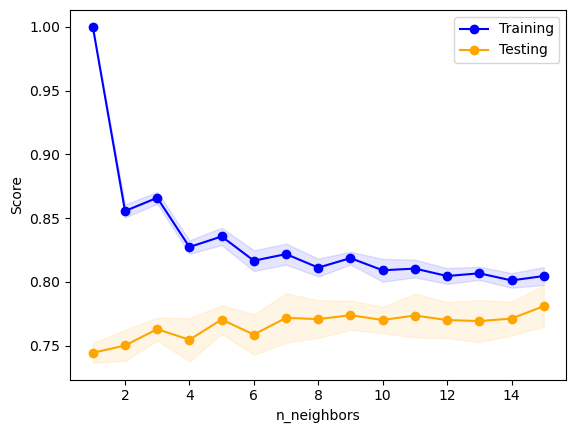

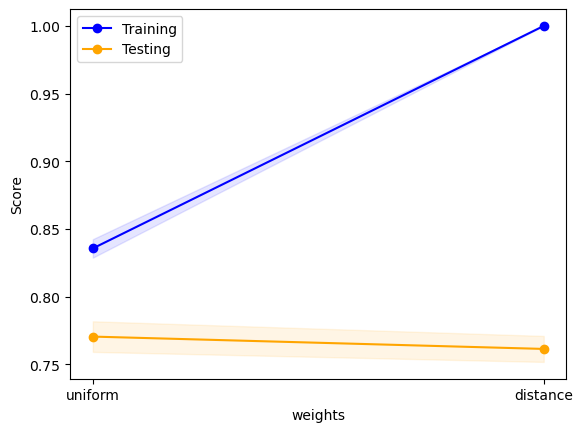

knn best params for salaries
{'n_neighbors': 15, 'weights': 'uniform'}


,Model,f1_weighted_score
0,Base Model,0.770381
1,Optimal Model,0.780874


In [65]:
knn = KNeighborsClassifier()
plot_learning_curve(knn, salaries_X_train, salaries_y_train, cv=5, n_jobs=-1)

param_name = 'n_neighbors'
param_range = range(1, 16)
plot_complexity_curve(knn, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

param_name = 'weights'
param_range = ['uniform', 'distance']
plot_complexity_curve(knn, salaries_X_train, salaries_y_train, param_name, param_range, cv=5, n_jobs=-1)

knn_param_grid = {'n_neighbors': range(1, 16), 'weights': ['uniform', 'distance']}
knn_best_model, knn_best_params = optimize_model(knn, salaries_X_train, salaries_y_train, knn_param_grid)
knn_best_model.fit(salaries_X_train, salaries_y_train)

knn_base_report = evaluate_model(knn, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)
knn_opt_report = evaluate_model(knn_best_model, salaries_X_train, salaries_y_train, salaries_X_test, salaries_y_test)

knn_scores = {'Base Model': knn_base_report[0], 'Optimal Model': knn_opt_report[0]}
knn_score_df = pd.DataFrame(list(knn_scores.items()), columns=['Model', 'f1_weighted_score'])

print('knn best params for salaries')
print(knn_best_params)

knn_score_df